Михаил Сурцуков Автоэнкодеры в Keras, Часть 2: Manifold learning и скрытые (latent) переменные.     
https://habr.com/ru/post/331500/

In [1]:
import numpy as np
from numpy import random as rng

import tensorflow as tf
from tensorflow.keras.datasets import mnist

(x_train,target_train),(x_test,target_test) = mnist.load_data()

x_train = x_train[:,:,:,np.newaxis].astype('float32')/ 255.
x_test  = x_test [:,:,:,np.newaxis].astype('float32')/ 255.

x_train.shape

(60000, 28, 28, 1)

In [2]:
from tensorflow.keras.models import Sequential
# from tensorflow.keras.models import Model

from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

from tensorflow.keras.regularizers import L1L2

def deep_sparse_aenc(lambda_l1,encoding_dim=16, im_shape = x_train.shape[1:]):
    model_enc = Sequential([
        Input(shape=im_shape),
        Flatten(),
        Dense(encoding_dim*4, activation='relu'),
        Dense(encoding_dim*3, activation='relu'),
        Dense(encoding_dim*2, activation='relu'),
        Dense(encoding_dim, activation='linear', activity_regularizer=L1L2(lambda_l1,0)),
    ], name='encoder')

    model_dec = Sequential([
          Input(shape=(encoding_dim,)),
          Dense(encoding_dim*2, activation='relu'),
          Dense(encoding_dim*3, activation='relu'),
          Dense(encoding_dim*4, activation='relu'),
          Dense(28*28, activation='sigmoid'),
          Reshape(im_shape)
    ], name='decoder')

    model_aenc = Sequential([model_enc,model_dec],name='autoencoder')
    
    return model_enc, model_dec, model_aenc


In [3]:
from tensorflow.keras.optimizers import Adam

model_enc, model_dec, model_aenc = deep_sparse_aenc(lambda_l1=0.)

model_aenc.compile(optimizer=Adam(.0003), loss='binary_crossentropy')

2022-06-08 11:18:24.707927: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 11:18:24.735998: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 11:18:24.736263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 11:18:24.736629: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
%%time

history = model_aenc.fit(
    x_train,x_train,
    epochs=200,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test,x_test),
)

Epoch 1/200
938/938 [==============================] - 3s 3ms/step - loss: 0.2519 - val_loss: 0.1859
Epoch 2/200
938/938 [==============================] - 2s 3ms/step - loss: 0.1705 - val_loss: 0.1568
Epoch 3/200
938/938 [==============================] - 2s 3ms/step - loss: 0.1539 - val_loss: 0.1490
Epoch 4/200
938/938 [==============================] - 2s 3ms/step - loss: 0.1480 - val_loss: 0.1441
Epoch 5/200
938/938 [==============================] - 2s 3ms/step - loss: 0.1435 - val_loss: 0.1405
Epoch 6/200
938/938 [==============================] - 3s 3ms/step - loss: 0.1399 - val_loss: 0.1368
Epoch 7/200
938/938 [==============================] - 3s 3ms/step - loss: 0.1365 - val_loss: 0.1334
Epoch 8/200
938/938 [==============================] - 3s 3ms/step - loss: 0.1330 - val_loss: 0.1300
Epoch 9/200
938/938 [==============================] - 2s 3ms/step - loss: 0.1306 - val_loss: 0.1281
Epoch 10/200
938/938 [==============================] - 2s 3ms/step - loss: 0.1289 - val_lo

Epoch 161/200
938/938 [==============================] - 2s 3ms/step - loss: 0.0975 - val_loss: 0.0969
Epoch 162/200
938/938 [==============================] - 3s 3ms/step - loss: 0.0975 - val_loss: 0.0971
Epoch 163/200
938/938 [==============================] - 3s 3ms/step - loss: 0.0975 - val_loss: 0.0971
Epoch 164/200
938/938 [==============================] - 2s 3ms/step - loss: 0.0975 - val_loss: 0.0969
Epoch 165/200
938/938 [==============================] - 3s 4ms/step - loss: 0.0975 - val_loss: 0.0970
Epoch 166/200
938/938 [==============================] - 2s 2ms/step - loss: 0.0974 - val_loss: 0.0969
Epoch 167/200
938/938 [==============================] - 3s 3ms/step - loss: 0.0974 - val_loss: 0.0970
Epoch 168/200
938/938 [==============================] - 2s 3ms/step - loss: 0.0974 - val_loss: 0.0972
Epoch 169/200
938/938 [==============================] - 2s 3ms/step - loss: 0.0973 - val_loss: 0.0968
Epoch 170/200
938/938 [==============================] - 2s 3ms/step - lo

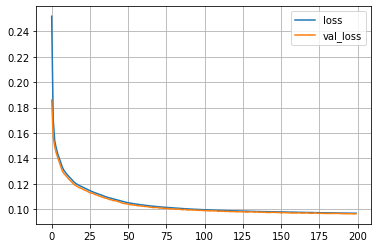

In [5]:
from matplotlib import pyplot as plt

for k in history.history:
    plt.plot(history.history[k],label=k)
plt.legend()
plt.grid()

In [6]:
def plot_digits(x):
    n = len(x)    
    plt.figure(figsize=(16,2))
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(x[i],cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()

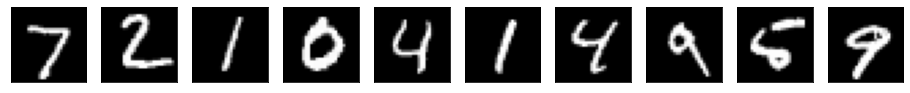

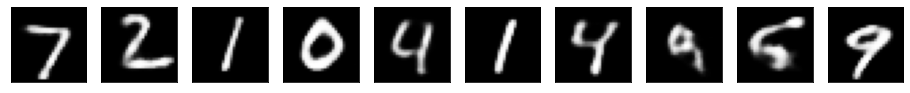

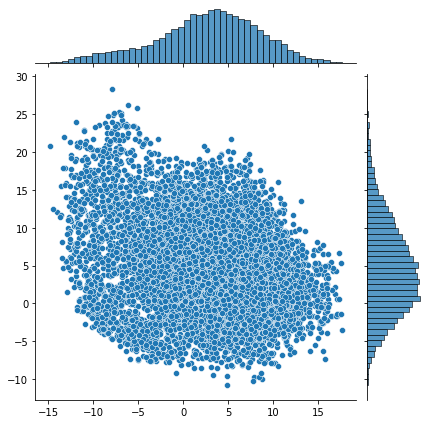

In [7]:
import seaborn as sns

n_samples = 10
imgs = x_test[:n_samples]
decoded_imgs = model_aenc.predict(imgs)

plot_digits(imgs)
plot_digits(decoded_imgs)


codes = model_enc.predict(x_test)
sns.jointplot(x=codes[:,1],y=codes[:,3])

----

In [8]:
model_enc, model_dec, model_aenc = deep_sparse_aenc(lambda_l1=1e-5)
model_aenc.compile(optimizer=Adam(.0003), loss='binary_crossentropy')

In [9]:
%%time

history = model_aenc.fit(
    x_train, x_train, 
    epochs=200, 
    batch_size=256,
    shuffle=True,
    validation_data=(x_test,x_test),
)

Epoch 1/200
235/235 [==============================] - 1s 4ms/step - loss: 0.3599 - val_loss: 0.2606
Epoch 2/200
235/235 [==============================] - 1s 3ms/step - loss: 0.2487 - val_loss: 0.2378
Epoch 3/200
235/235 [==============================] - 1s 3ms/step - loss: 0.2280 - val_loss: 0.2172
Epoch 4/200
235/235 [==============================] - 1s 3ms/step - loss: 0.2079 - val_loss: 0.1943
Epoch 5/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1834 - val_loss: 0.1709
Epoch 6/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1664 - val_loss: 0.1608
Epoch 7/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1597 - val_loss: 0.1558
Epoch 8/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1546 - val_loss: 0.1506
Epoch 9/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1497 - val_loss: 0.1463
Epoch 10/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1463 - val_lo

Epoch 161/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1027 - val_loss: 0.1018
Epoch 162/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1026 - val_loss: 0.1017
Epoch 163/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1026 - val_loss: 0.1018
Epoch 164/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1026 - val_loss: 0.1018
Epoch 165/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1026 - val_loss: 0.1017
Epoch 166/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1025 - val_loss: 0.1017
Epoch 167/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1025 - val_loss: 0.1017
Epoch 168/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1025 - val_loss: 0.1017
Epoch 169/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1024 - val_loss: 0.1016
Epoch 170/200
235/235 [==============================] - 1s 3ms/step - lo

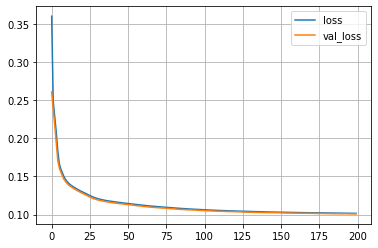

In [10]:
for k in history.history:
    plt.plot(history.history[k],label=k)
plt.legend()
plt.grid()

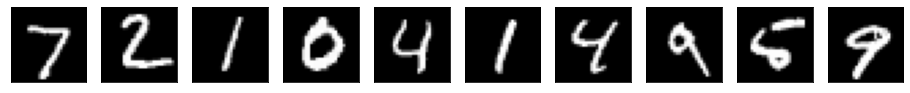

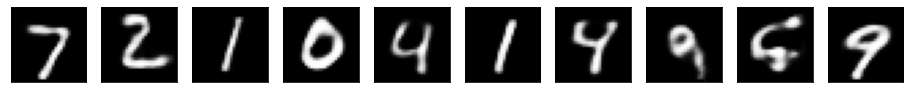

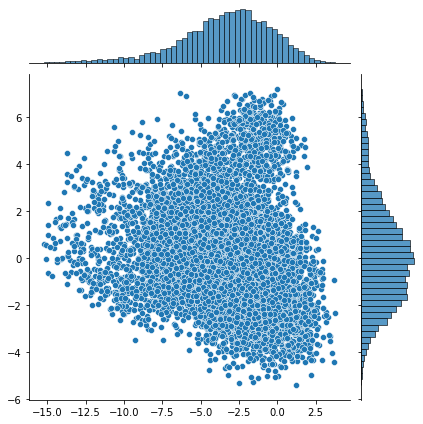

In [11]:
imgs = x_test[:n_samples]
decoded_imgs = model_aenc.predict(imgs)

plot_digits(imgs)
plot_digits(decoded_imgs)

codes = model_enc.predict(x_test)
sns.jointplot(x=codes[:,1],y=codes[:,3])

----

In [12]:
# !pip3 install watermark
# Python package versions used
%load_ext watermark
%watermark --python
%watermark --iversions
#

Python implementation: CPython
Python version       : 3.8.9
IPython version      : 8.0.1

keras     : 2.8.0
seaborn   : 0.11.2
numpy     : 1.22.2
matplotlib: 3.5.1
tensorflow: 2.8.0

